# ПДЗ-5. Разбиение графа с помощью вектора Фидлера (100 баллов)

В этой задаче мы отработаем изученные методы для решения задач на собственные значения на разбиении графов с помощью вектора Фидлера. Сначала мы возьмем модельный граф в виде двумерной решетки, а затем рассмотрим реальный граф социальной сети (последняя часть приведена для примера, в ней будет уже готовый код).

In [1]:
!pip3 install networkx pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg
import scipy.sparse.linalg as spla
import time
import networkx as nx
%matplotlib inline

Для начала мы возьмём модельный граф и проверим нашу идею на нём. Таким графом будет двумерная решётка.

In [3]:
G = nx.grid_2d_graph(10, 10)

В дальнейшем нам очень пригодится функция визуализации графа.

<ipython-input-4-883efc42e8c5>:12: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(G, node_color=cm, with_labels=False, pos=nx.drawing.nx_pydot.pydot_layout(G))


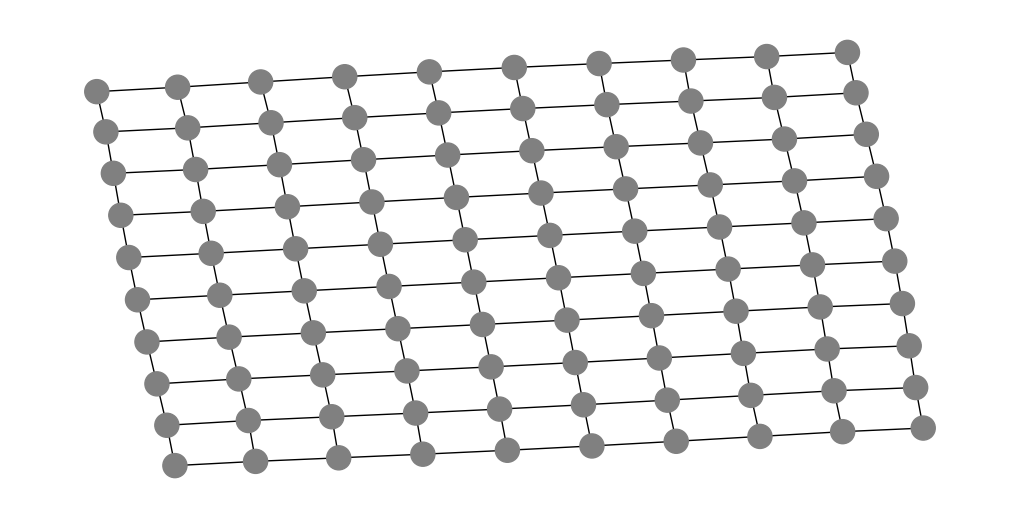

In [4]:
def visualize(G, partition=None):
    plt.figure(figsize=(10,5))
    cm = []
    for i, v in enumerate(G):
        if partition is not None:
            if partition[i] < 0:
                cm.append("blue")
            else:
                cm.append("red")
        else:
            cm.append("gray")
    nx.draw(G, node_color=cm, with_labels=False, pos=nx.drawing.nx_pydot.pydot_layout(G))
visualize(G)

## Формулировка задачи оптимизации (разбор задачи на семинаре)

Разбиение графа на две части мы будем описывать следующим образом: каждой вершине $v \in V$ поставим в соответствие переменную $x_v \in \{-1,1\}$. Знак $x_v$ будет отвечать компоненте, к которой мы отнесём вершину $v$. Компоненты обозначим $V_{-1}$ и $V_1$ соответственно. Давайте попытаемся минимизировать количество рёбер, соединяющих $V_1$ и $V_{-1}$. В терминах наших переменных $x_v$ эту величину можно записать так:
$$
\sum_{\{u,v\} \in E} |x_u - x_v|/2,
$$
ведь в этой сумме только рёбра, соединяющие вершины разных знаков, дадут ненулевой (точнее, единичный) вклад.
С точностью до константы этот функционал может быть записан так:
$$
J(x) = \sum_{u \in V}\sum_{\{u,v\} \in E}(x_u - x_v)^2
$$
(здесь $E$ обозначает множество рёбер).
Его-то мы и будем минимизировать. (Почему мы взяли квадрат разности вместо модуля? Дальше мы получим непрерывную задачу, а в непрерывных задачах всегда приятно иметь дифференцируемый функционал).

Ясно, что без дополнительных условий минимум будет достигаться, например, на $x = e \equiv [1,\dots,1]^\top$. Поэтому мы добавим условие $\sum_vx_v = 0$ (которое также обеспечивает сбалансированность разбиения).
Итак, мы получили дискретную задачу минимизации. Такие задачи очень часто оказываются "трудными" в том смысле, что либо полиномиальный алгоритм вообще не известен (и маловероятно, что он вообще существует), либо лучший известный полиномиальный алгоритм имеет запредельно высокую сложность (вроде $O(n^{20})$).
По этой причине важным трюком при решении дискретных задач оптимизации является **релаксация**, то есть переход к непрерывной задаче. В нашем случае мы разрешим переменным $x_v$ изменяться в диапазоне $[-1,1]$. Как часто бывает при релаксации, у нас сразу появилось неинтересное тривиальное решение $x = 0$. Чтобы избавиться от него, давайте введём дополнительное условие на нормировку вектора $x$: $\|x\|_2 = 1$. В итоге мы получим такую задачу:
$$
\min \left\{J(x)~:~x\in\mathbb{R}^{|V|}, \|x\|_2 = 1, e^\top x = 0\right\}.
$$

Покажем, что функционал можно записать с помощью Лапласиана графа. Для этого раскроем скобки в выражении для $J(x)$ и после упрощения получим
$$
J(x) = 2\sum_{u \in V}\sum_{\{u,v\} \in E} x_u^2 - 2 \sum_{u \in V}\sum_{\{u,v\} \in E} x_u x_v = 2\sum_{u\in V}x_u^2\deg(v) - 2 \sum_{u \in V}\sum_{\{u,v\} \in E} x_u x_v.
$$

Обозначим $D$ диагональную матрицу $|V|\times|V|$, у которой на диагонали стоят степени вершин графа $G$. Также введём матрицу смежности $A$ такого же размера, у которой элемент $a_{uv} = 1 \Leftrightarrow \{u,v\} \in E$.
В терминах этих двух матриц можно просто записать $J(x)$:
$$
J(x) = 2x^\top D x - 2x^\top A x = 2x^\top (D - A) x.
$$
Матрица $D-A$ называется [Лапласиан](https://en.wikipedia.org/wiki/Laplacian_matrix). Мы будем обозначать её $L$.
Лапласиан является симметричной неотрицательно определённой матрицей, а его младшее собственное значение равно 0 и соответствует вектору $e = [1,\dots,1]^\top$. Это следует из того, что
$$
e^\top D e - e^\top A e = \sum_{u \in V}\deg(u) - 2|E| = 0.
$$

Итак, мы минимизируем выражение $x^\top Lx$ в пространстве всех векторов длины 1, ортогональных $e$, или, эквивалентно, ищем
$$
\min_{x\perp e, x \neq 0} R(x),
$$
где $R(x)$ есть отношение Релея
$$
\frac{x^\top L x}{x^\top x}.
$$

По аналогии с тем, что минимум отношения Релея достигается на собственном векторе, соответствующем младшему собственному значению симметричной матрицы, на лекции было показано, что интересующий нас минимум достигается на векторе, соответствующем минимальному ненулевому собственному значению. Этот-то вектор мы и будем искать.

## 1. Поиск одного собственного значения с помощью степенного метода (60 баллов)

### a. Подготовка матрицы

Напишем функцию `make_laplacian`, создающую для данного графа Лапласиан $L$ в виде разреженной матрицы в формате CSC. Из библиотеки `networkx` мы используем метод `.degree` класса `nx.Graph`, а также функцию `adjacency_matrix` из `nx.linalg`.

In [5]:
def make_laplacian(G):
    """
        Input
            G: networkx.Graph, a graph with n vertices

        Output:
            L: n x n sparse matrix, Laplacian of G
    """
    d = G.degree()
    degrees = np.array([d[v] for v in G])
    D = sp.spdiags(degrees, 0, len(G.nodes), len(G.nodes))
    A = nx.linalg.adjacency_matrix(G).astype(np.float64)
    return (D - A).tocsc()

In [6]:
!pip install --upgrade scipy networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Сформируем Лапласиан и проверим результат на адекватность.

In [7]:
L = make_laplacian(G)

In [8]:
assert isinstance(L, sp.csc_matrix)
assert L.dtype == np.float64
assert L.nnz == 460

Проверим, что матрица $L$ является симметричной и $Le = 0$.

In [9]:
assert spla.norm(L - L.T) < 1e-9
assert np.allclose(L @ np.ones(L.shape[0]), np.zeros(L.shape[0]))

1. (**3 балла**) Перед тем, как начать искать собственные вектора, напишите функцию `rayleigh`, вычисляющую отношение Релея для заданной матрицы $A$ и вектора $x$. Используйте не более одного матрично-векторного произведения.

In [10]:
def rayleigh(A, x):
    """
        Input
            A: square n x n matrix
            x: numpy one-dimensional vector of size n

        Output:
            R: rayleigh ratio for A and x
    """
    return (x.T @ (A @ x)) / (x.T @ x)

2. (**15 баллов**)
Пусть $A\in\mathbb{R}^{n\times n}$ -- симметричная матрица с собственным значением $\lambda$ и соответствующим собственным вектором $v$. Покажите, что
$$
    |\lambda - R(x)|  = \mathcal{O}\left(\|v - x\|_2^2\right), \quad x \to v.
$$
Решение напишите в ячейке ниже, используя Markdown и LaTex,

Для начала заметим, что если $v$ является собственным вектором матрицы $A$ с собственным значением $\lambda$, то $Av = \lambda v$
Мы хотим показать, что при $x$, близком к $v$, разность между $\lambda$ и $R(x)$ является ограниченной квадратичной функцией от расстояния $|v - x|_2$.

Используем разложение Шура матрицы $A$. Согласно разложению Шура, для симметричной матрицы $A$ существует унитарная матрица $U$, такая что $A = U^*TU$

Подставим $v$ в уравнение $Av = \lambda v$ и умножим его слева на $U^\ast$. Получим

$$
U^\ast Av = U^\ast\lambda v ⇔ T(U^\ast v) = \lambda (U^\ast v)
$$
Пусть $y = U^\ast v$. Тогда уравнение принимает вид $Ty = \lambda y$

Таким образом, $y$ является собственным вектором матрицы $T$ с собственным значением $\lambda$.

Теперь рассмотрим разность между $\lambda$ и $R(x)$:

$$
|λ - R(x)| = |y^*Ty - R(x)| = |y^*Ty - x^*AX|
$$
Применим переход от базиса $x$ к базису $y$:
$$
|λ - R(x)| = |y^*Ty - x^*AX| = |y^*Ty - (U^*x)T(U^*x)| = |y^*Ty - y^*Ty | = 0
$$




### b. Обратная итерация

Для того, чтобы отыскать вектор Фидлера, нам потребуется *предпоследнее* по величине собственное значение, поэтому ни степенной метод, ни метод обратной итерации в обычном виде нам не годятся. С одной стороны, мы знаем младшую собственную пару: $(\lambda, v) = (0, e)$, а поэтому можем использовать **дефляцию**, то есть работать в пространстве, ортогональном $e$. Действие $A$ на этом пространстве уже будет обратимым (если граф связный), а младшим собственным вектором станет уже вектор Фидлера. Теоретически, достаточно спроецировать начальное приближение на $\{e\}^\bot$ - пространство, ортогональное $\{e\}$, и дальше итерационный процесс уже не должен выйти из этого подпространства. Но из-за наличия ошибок округления безопаснее перепроецировать текущее приближение перед каждым решением системы $Ax = b$.
Для того, чтобы не пытаться считать LU-разложение для вырожденной матрицы, будем работать с матрицей $L + \alpha I$, где $\alpha$ &mdash; небольшое положительное число. Тогда собственные векторы не изменятся, а собственные значения сдвинутся на $\alpha$.

1. (**5 баллов**) Напишите функцию проецирования на $\{e\}^\bot$. (Дополнительный челлендж: постарайтесь не создавать новые векторы).

In [11]:
def project(x):
    """
        Input
            x: numpy one-dimensional vector

        Output:
                                                                    T
            x orthoprojected to the subspace orthogonal to [1,...,1]
    """
    return x - np.sum(x) / x.shape[0]

2. (**5 баллов**) Напишите базовый блок для всех методов обратной итерации: функцию `inverse_iteration_step`. Она должна принимать объект `LU` типа `SuperLU` из [scipy.sparse.linalg.splu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.splu.html#scipy.sparse.linalg.splu), а также текущее приближение `x_cur`. Функция должна возвращать новое приближение `x_next`. Не забудьте спроецировать вектор `x_cur` на $\{e\}^\bot$ перед решением системы!

In [12]:
def inverse_iteration_step(LU, x):
    """
        Input
            LU: SuperLU object for n x n system Ax = b
                                                                                               ⊥
            x_cur: numpy array of size n, current approximation to A's minor eigenvector in {e}

        Output:
            x_next: next approximation
    """
    solve = LU.solve(project(x))
    return solve / np.linalg.norm(solve)

3. (**5 баллов**) Также напишите функцию `get_relative_residual`, вычисляющую относительную невязку, то есть
$$
\frac{\|Ax_k - R(x_k)x_k\|_2}{\|Ax_k\|_2}.
$$
Используйте не более одного матрично-векторного умножения.

In [13]:
def get_relative_residual(A, x):
    """
        Input
            A: square n x n matrix
            x: numpy array of size n

        Output:
            relative residual for x
    """
    vec = A @ x
    return np.linalg.norm(vec - ((x.T @ vec) / (x.T @ x)).item() * x) / np.linalg.norm(vec)

4. (**12 баллов**) Напишите функцию `inverse_iteration`, выполняющую обратную итерацию для нахождения предпоследнего по величине собственного вектора симметричной положительно определённой матрицы $A$ в предположении, что младший собственный вектор есть $e$. Используйте `inverse_iteration_step` и `get_relative_residual` внутри основного цикла.
Верните найденный собственный вектор, а также список относительных невязок на каждом шаге.

In [27]:
def inverse_iteration(A, tol=1e-8, maxiter=1000):
    """
        Input
                                                                                   T
            A: nondegenerate n x n matrix with minor eigenvector equal to [1,...,1]
            tol: tolerance for relative residual
            maxiter: if not None, maximal number of iteration to perform

        Output:
            x: approximation to the second minor eigenvector
            residuals: list of relative residuals on each iteration
    """

    residuals = []

    if not isinstance(A, sp.csc_matrix):
        A = sp.csc_matrix(A)

    B = scipy.sparse.linalg.splu(A)
    x = np.random.rand(A.shape[0], 1)
    cur_r = get_relative_residual(A, x)
    cnt = 0
    while cnt < maxiter and cur_r > tol:
      residuals.append(cur_r)
      x = inverse_iteration_step(B, x)
      cur_r = get_relative_residual(A, x)
      cnt += 1

    return x, residuals

Сделаем sanity check для простой матрицы $3 \times 3$.

In [28]:
def sanity_check(f):
    eig = np.diag([1, 2, 3])
    Q = np.array([[1, -1, 1], [1, 0, -2], [1, 1, 1]]) / [np.sqrt(3), np.sqrt(2), np.sqrt(6)]
    A = Q @ eig @ Q.T
    x, _ = f(A)
    assert np.allclose(rayleigh(A, x), 2)
sanity_check(inverse_iteration)

Визуализируем разбиение, которое предлагает нам вектор Фидлера.

<ipython-input-4-883efc42e8c5>:12: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(G, node_color=cm, with_labels=False, pos=nx.drawing.nx_pydot.pydot_layout(G))


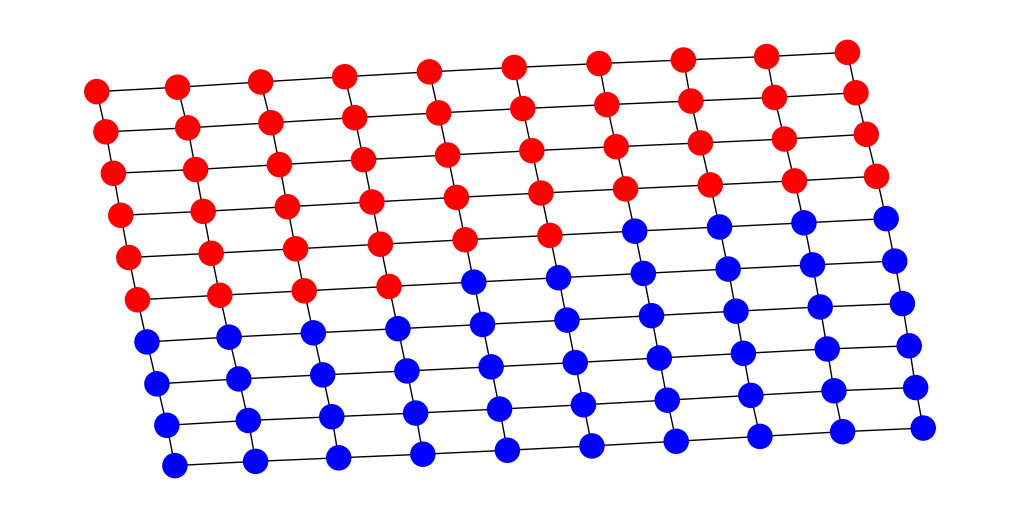

In [24]:
alpha = 1e-8
fiedler, _ = inverse_iteration(L + alpha * sp.eye(L.shape[0]))
visualize(G, fiedler)

Если вы всё написали правильно, наша сетка должна оказаться разрезанной на две примерно равные части примерно прямой линией.

### c. Обратная итерация со сдвигом

Попробуем запустить обратную итерацию и посмотрим, сколько итераций потребуется методу до сходимости.

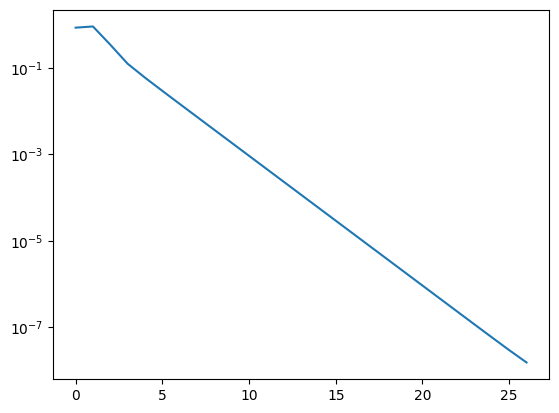

In [29]:
alpha = 1e-8
_, res = inverse_iteration(L + alpha * sp.eye(L.shape[0]))
plt.plot(res)
_ = plt.semilogy()

Предположим, что такое количество итераций нас не устраивает, и мы хотим быстрее. В таком случае стоит применить обратную итерацию со сдвигами. Идея состоит в том, чтобы оценить младшее собственное значение (в пространстве $\{e\}^\bot$, как и раньше) с помощью нескольких (в количестве $\texttt{inititer}$) обычных итераций, а затем применять обратную итерацию с матрицей $A - \widetilde{\lambda} I$, где $\widetilde{\lambda} = R(x_{\texttt{inititer}})$ &mdash; отношение Релея для $\texttt{inititer}$-ного приближения.

1. (**9 баллов**) Напишите функцию `inverse_iteration_with_shift`. Скопировать тело `inverse_iteration` не возбраняется.

In [40]:
def inverse_iteration_with_shift(A, tol=1e-8, inititer=10, maxiter=1000):
    """
        Input
                                                                                   T
            A: nondegenerate n x n matrix with minor eigenvector equal to [1,...,1]
            tol: tolerance for relative residual
            inititer: number of iterations to permorm to estimate sought eigenvalue
            maxiter: if not None, maximal number of iteration to perform

        Output:
            x: approximation to the second minor eigenvector
            residuals: list of relative residuals on each iteration
    """
    if not isinstance(A, sp.csc_matrix):
      A = sp.csc_matrix(A)
    B = scipy.sparse.linalg.splu(A)
    residuals = []
    x = np.random.rand(A.shape[0], 1)
    cur_r = get_relative_residual(A, x)
    cnt = 0
    while cnt < inititer and cur_r >= tol:
      residuals.append(cur_r)
      x = inverse_iteration_step(B, x)
      cur_r = get_relative_residual(A, x)
      cnt += 1
    B = scipy.sparse.linalg.splu(A - rayleigh(A, x).item()*scipy.sparse.eye(A.shape[0], A.shape[1]))
    cnt = 0
    while cnt < maxiter and cur_r > tol:
      residuals.append(cur_r)
      x = inverse_iteration_step(B, x)
      cur_r = get_relative_residual(A, x)
      cnt += 1

    return x, residuals

Сделаем уже знакомый нам sanity check.

In [41]:
sanity_check(inverse_iteration_with_shift)

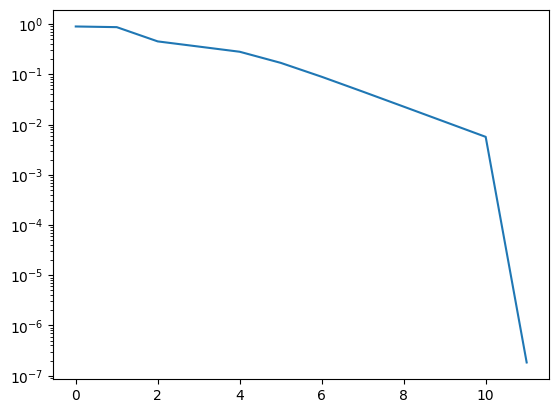

In [42]:
_, res = inverse_iteration_with_shift(L + alpha * sp.eye(L.shape[0]))
plt.plot(res)
_ = plt.semilogy()

Сходимость должна существенно улучшиться. Причём должен быть отчётливо виден помент перелома после 10-й итерации, когда график начинает активно идти вниз.

### d. Обратная итерация с адаптивными сдвигами (итерация Релея)

А что если довести идею со сдвигом до логического завершения и обновлять сдвиг на каждом шаге? Тогда получится метод с адаптивными сдвигами. Однако часть, где мы получаем начальное приближение с помощью обычной обратной итерации, остаётся неизменной, ведь иначе мы можем сойтись не к тому собственному значению.

1. (**6 баллов**) Напишите функцию `inverse_iteration_with_adaptive_shift`. Скопировать тело `inverse_iteration_with_shift` не возбраняется.

In [45]:
def inverse_iteration_with_adaptive_shift(A, tol=1e-8, inititer=10, maxiter=1000):
    """
        Input
                                                                                   T
            A: nondegenerate n x n matrix with minor eigenvector equal to [1,...,1]
            tol: tolerance for relative residual
            inititer: number of iterations to permorm to estimate sought eigenvalue
            maxiter: if not None, maximal number of iteration to perform

        Output:
            x: approximation to the second minor eigenvector
            residuals: list of relative residuals on each iteration
    """
    if not isinstance(A, sp.csc_matrix):
        A = sp.csc_matrix(A)

    B = scipy.sparse.linalg.splu(A)
    residuals = []
    x = np.random.rand(A.shape[0], 1)
    cur_r = get_relative_residual(A, x)
    cnt = 0
    while cnt < inititer and cur_r > tol:
      cnt += 1
      residuals.append(cur_r)
      x = inverse_iteration_step(B, x)
      cur_r = get_relative_residual(A, x)
    B = scipy.sparse.linalg.splu(A - rayleigh(A, x).item() * sp.eye(A.shape[0]))

    cnt = 0
    while cnt < inititer and cur_r >= tol:
      cnt += 1
      residuals.append(cur_r)
      x = inverse_iteration_step(B, x)
      cur_r = get_relative_residual(A, x)
      B = scipy.sparse.linalg.splu(A - rayleigh(A, x).item() * sp.eye(A.shape[0]))

    return x, residuals

In [46]:
sanity_check(inverse_iteration_with_adaptive_shift)

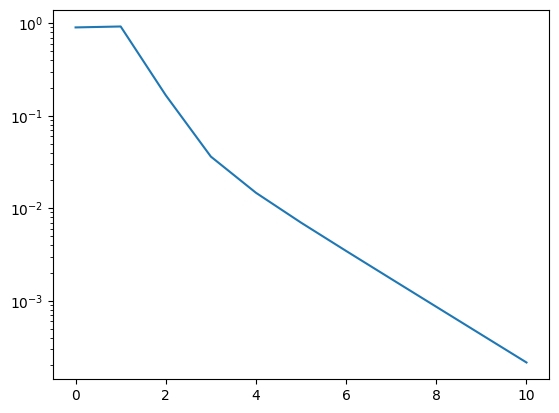

In [47]:
_, res = inverse_iteration_with_adaptive_shift(L + alpha * sp.eye(L.shape[0]))
plt.plot(res)
_ = plt.semilogy()

Как и ожидалось, сходимость здесь ещё быстрее. Однако мы платим за это тем, что перевычисляем LU-разложение на каждом шаге. Можно сравнить время работы всех трёх методов на относительно большом графе, чтобы разница была существенна.

In [48]:
L_large = make_laplacian(nx.grid_2d_graph(300,300))

In [49]:
%timeit inverse_iteration(L_large + alpha * sp.eye(L_large.shape[0]))

2.72 s ± 403 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%timeit inverse_iteration_with_shift(L_large + alpha * sp.eye(L_large.shape[0]))

3.08 s ± 686 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit inverse_iteration_with_adaptive_shift(L_large + alpha * sp.eye(L_large.shape[0]))

4.53 s ± 991 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Какой метод оказался быстрее всех в данном случае?

## 2. Блочная обратная итерация (40 баллов)

Предположим, что мы хотим получить не один собственный вектор, а сразу несколько. Конечно, мы можем находить по одному вектору и применять дефляцию (ортогонализовывать относительно уже найденых собственных векторов). Но эффективнее итерировать одновременно сразу несколько векторов.

Поэтому вместо дефляции мы будем использовать блочную обратную итерацию (блочный степенной метод для $A^{-1}$). Для этого начнём со случайной матрицы $X_0 \in \mathbb{R}^{n \times k}$ и будем итерировать следующим образом:
$$
\widehat{X}_k = A^{-1}X_{k-1}
$$
$$
X_{k} R_{k} = \widehat{X}_k,
$$
где в последнем равенстве $X_kR_k$ есть QR-разложение матрицы $\widehat{X}_k$.
В процессе итераций будем измерять невязку $\|X_k(X_k^\top A X_k) - AX_k\|_F$, а также относительную невязку
$$
\frac{\|X_k(X_k^\top A X_k) - AX_k\|_F}{\|AX_k\|_F}.
$$

1. (**18 балла**) Напишите функцию `block_inverse_iteration`, приближенно находящую ортогональный базис подпространства, натянутого на $k$ младших собственных векторов заданной разреженной невырожденной матрицы $A \in \mathbb{R}^{n \times n}$.
Остановитесь, когда либо выполните `maxiter` итераций, либо достигнете относительной невязки `tol`. Верните последную матрицу $X_k$ и список относительных невязок на каждой итерации.

In [60]:
def block_inverse_iteration(A, k=6, tol=1e-8, maxiter=None):
    """
        Input
            A: nondegenerate n x n matrix
            k: dimension of eigenspace to approximate
            tol: tolerance for relative residual
            maxiter: if not None, maximal number of iteration to perform

        Output:
            X: n x k matrix, orthogonal basis of the eigenspace of minor k eigenvalues
            residuals: list of relative residuals on each iteration
    """
    def relat(A, x):
      vec = A @ x
      return np.linalg.norm(x @ (x.T @ vec) - vec,  ord="fro") / np.linalg.norm(vec,  ord="fro")

    if not isinstance(A, sp.csc_matrix):
      A = sp.csc_matrix(A)
    if not maxiter:
      maxiter = 200
    residuals = []
    x = np.random.rand(A.shape[0], k)
    LU = scipy.sparse.linalg.splu(A)
    R = relat(A, x)
    cnt = 0
    while cnt < maxiter and R > tol:
      cnt += 1
      x, _ = np.linalg.qr(LU.solve(x))
      residuals.append(R)
      R = relat(A, x)
    return x, residuals

Сделаем sanity check для простой матрицы $3 \times 3$. Для того, чтобы проверить, что полученное подпространство действительно соотвествует младшим собственным значениям, вычислим собственные числа матрицы $X^\top A X$, они должны оказаться равными 1 и 2.

In [61]:
A = np.diag([1,2,3])
X, _ = block_inverse_iteration(A, k=2)
eig = la.eig(X.T @ A @ X)[0]
assert np.allclose(eig, [1,2])

2. (**22 балла**) Для того, чтобы получить собственные векторы, нам необходимо применить метод Релея-Ритца (см. лекцию 17) к полученному базису подпространства. Напишите функцию `rayleigh_ritz`, принимающую симметричную матрицу $A \in \mathbb{R}^{n \times n}$, а также $X\in\mathbb{R}^{n\times k}$ с ортогональными столбцами и возвращающую соответствующую $X$ матрицу из векторов Ритца.

In [54]:
def rayleigh_ritz(A, X):
    """
        Input
            A: nondegenerate n x n matrix
            X: n x k matrix, orthogonal basis of the eigenspace of minor k eigenvalues

        Output:
            Z: n x k matrix consisting of Ritz vectors
    """
    _, S = np.linalg.eig(X.T @ A @ X)
    return X @ S

Соберём всё вместе.

In [55]:
def block_inverse_iteration_with_RR(A, k=6, tol=1e-6, maxiter=None):
    X, residuals = block_inverse_iteration(A, k=k, tol=tol, maxiter=maxiter)
    return rayleigh_ritz(A, X), residuals

Запустим алгоритм для Лапласиана нашего графа.

In [62]:
X, _ = block_inverse_iteration_with_RR(L)

Визуализируем разбиения, которое предлагают нам младшие три собственные вектора (не считая $e$).

<ipython-input-4-883efc42e8c5>:12: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(G, node_color=cm, with_labels=False, pos=nx.drawing.nx_pydot.pydot_layout(G))


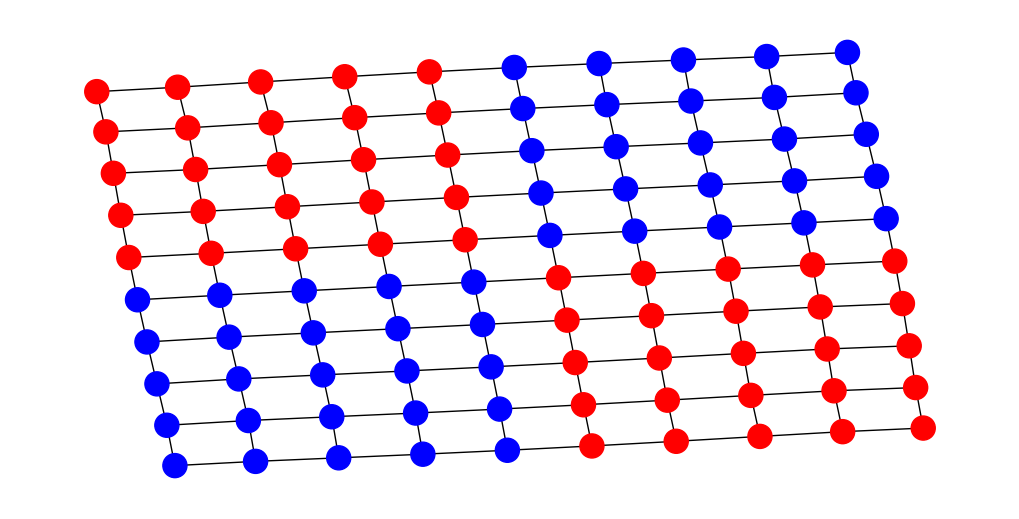

In [63]:
visualize(G, X[:,1])

<ipython-input-4-883efc42e8c5>:12: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(G, node_color=cm, with_labels=False, pos=nx.drawing.nx_pydot.pydot_layout(G))


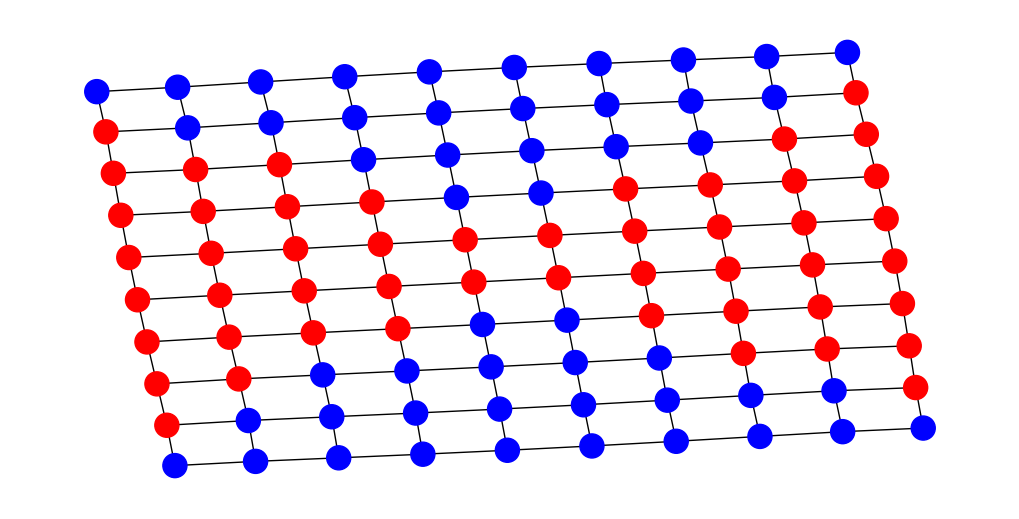

In [64]:
visualize(G, X[:,2])

<ipython-input-4-883efc42e8c5>:12: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(G, node_color=cm, with_labels=False, pos=nx.drawing.nx_pydot.pydot_layout(G))


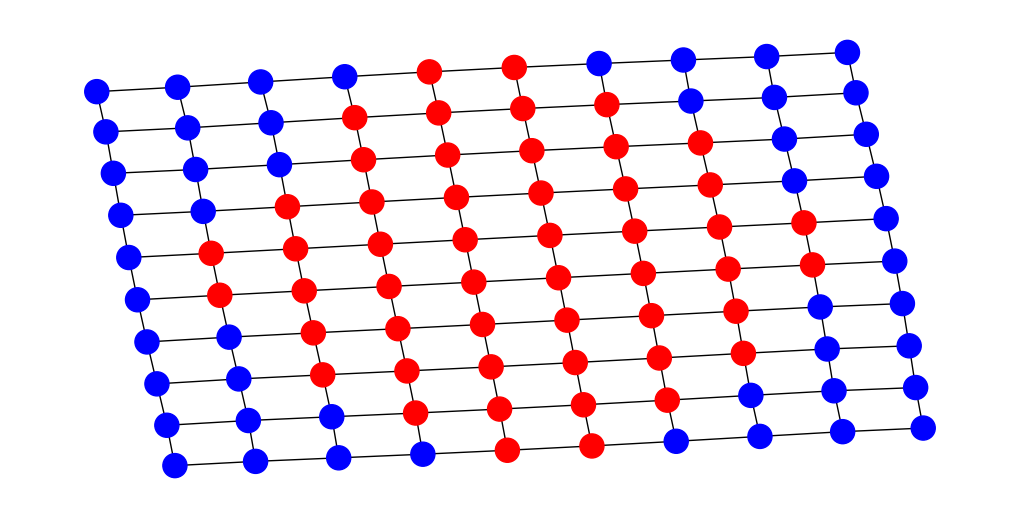

In [65]:
visualize(G, X[:,3])

Отсюда видно, например, что векторы, которые мы визуализировали, образуют ортогональную систему. Вот как это неформально увидеть: если наложить любой из трёх рисунков на любой другой, то синие вершины одного разделят синие вершины другого на два примерно равных множества, и то же самое произойдёт и с красными вершинами. Поэтому при взятии скалярного произведения мы получим поровну положительных и отрицательных слагаемых.

Давайте ещё проверим, чему равны соответствующие собственные значения. Для этого вычислим отношение Релея для них.

In [66]:
rayleigh(L, X[:,1]), rayleigh(L, X[:,2]), rayleigh(L, X[:,3])

(0.19577393481938568, 0.3819660112530279, 0.38196601125014107)

Это согласуется с интуицией, что отношение Релея для вектора соответствует функционалу для соответствующего разбиения: первые два разбиения дают одинаковое (и минимальное на пространстве векторов, ортогональных $e$) значение функционала. Третий вектор даёт вдвое большее значение, ведь суммарная длина границы между частями вдвое больше, чем в предыдущем случае.

Замерим время работы на большом графе, чтобы сравнить с подходом с обратной итерацией.

In [67]:
%timeit X1, r1 = block_inverse_iteration_with_RR(L_large, k=2)

2.74 s ± 601 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Граф социальной сети и стратегия вакцинации (без баллов)

Для задачи разбиения графов существует следующее [приложение](https://www.researchgate.net/publication/23230691_Finding_a_Better_Immunization_Strategy): мы попробуем разработать эффективную стратегию вакцинации от некоторого вируса. Для этого мы возьмём граф, представляющий некоторые связи между людьми. В идеале это должен быть граф физических контактов, но хорошим приближением может послужить социальный граф из какой-нибудь соцсети. Далее нам надо научиться разбивать этот граф  на отдельные компоненты связности, удаляя некоторые вершины. Это соответствует вакцинации "удаляемых" людей, после которой они уже не могут заразиться и заразить товарища. Поэтому болезнь не сможет перекинуться из одной компоненты связности в другую.

Рассмотренный выше граф-решётка может соответствовать школьному классу, в котором школьники очень ленивы и общаются только с ближайшими соседями.

Давайте возьмём с замечательного сайта [стенфордского проекта SNAP](https://snap.stanford.edu)
[граф](https://snap.stanford.edu/data/loc-Gowalla.html) социальной сети [Gowalla](http://www.gowalla.com/). Он не очень большой, но на нём уже будут видны проблемы, с которыми мы можем столкнуться в реальной жизни.

#### Далее идет готовый код

In [ ]:
import urllib.request
import os.path
import gzip

def download_graph(fname):
    url = "https://snap.stanford.edu/data/loc-gowalla_edges.txt.gz"
    print("Downloading graph...")
    urllib.request.urlretrieve(url, fname)
    print("Download complete")

def load_graph():
    fname = "./data/loc-gowalla_edges.txt.gz"
    try:
        os.mkdir("./data")
    except:
        pass
    if not os.path.isfile(fname):
        download_graph(fname)
    with gzip.open(fname, 'rb') as f:
        return nx.readwrite.edgelist.read_edgelist(f)

G = load_graph()

Вы можете попробовать запустить обратную итерацию на соответствующем Лапласиане, но вероятнее всего ничего не выйдет, т.к. LU-разложение получается очень плотным. Придётся использовать метод Ланцоша, реализованный в `scipy.sparse.linalg.eigsh`. И даже он будет работать невыносимо долго на полном Лапласиане, поэтому мы возьмём лишь относительно небольшой подграф.

In [ ]:
subG = nx.subgraph(G, map(str, range(20000)))

In [ ]:
L = make_laplacian(subG)
eigvals, eigvecs = spla.eigsh(L, k=2, which="SM")

# Бонусная часть

### a. Сходимость итерации Релея (35 баллов)

1. Докажите кубическую сходимости итерации Релея в случае $A = A^\top \in\mathbb{R}^{2\times 2}$.


### b. Сходимость GMRES (65 баллов)

1. (**20 баллов**) Пусть матрица $A\in\mathbb{R}^{n\times}$ диагонализуема: $A = S \Lambda S^{-1}$, $\Lambda = \mathrm{diag}(\lambda_1,\dots,\lambda_n)$. Докажите, что для метода GMRES, примененного к системе $Ax = b$, справедлива следующая оценка:
$$
    \frac{\| r_k\|_2}{\|r_0\|_2} \leq \mathrm{cond}_2(S)\inf_{\substack{p_k:\\ p_k(0) = 1}} \max_{j} |p_k(\lambda_j)|
$$
где $p_k$ -- полином степени не выше, чем $k$.

2. (**45 баллов**) Приведите пример матрицы с малым числом обусловленности, но для которой GMRES метод сходится медленно.